# MARBERT Baseline Training for merged Arabic & english translation Polarization Detection

This notebook trains and evaluates MARBERT and MARBERT v2 models on the preprocessed Arabic and english translated dataset.

**Dataset**: Cleaned Arabic merged with english translated dataset text with polarization labels  
**Models**:
- MARBERT (UBC-NLP/MARBERT)
- MARBERT v2 (UBC-NLP/MARBERTv2)

**Task**: Binary classification (polarization detection)

## Setup: Install Required Packages

In [1]:
!pip install transformers torch scikit-learn pandas numpy tqdm accelerate -q

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


## Load and Explore Dataset

In [ ]:
# Load the cleaned dataset
# Note: Update the path if running on Colab and data is uploaded
data_path = 'arb_eng2arb_clean_basic.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['polarization'].value_counts())
print(f"\nClass balance:")
print(df['polarization'].value_counts(normalize=True))

Dataset loaded successfully!
Shape: (3380, 3)
Columns: ['id', 'text', 'polarization']

First few rows:
                                     id  \
0  arb_a2a60c8b4af3389e842d8ec31afb0eea   
1  arb_6723e56a672674a6c1d9b28b213c4a05   
2  arb_b0365d606edeee38ae6c025b1ca33e96   
3  arb_858c0ee684049ba6f416a6cecb0b0761   
4  arb_bdafc73afd0bc2cd2badae2a089446b9   

                                                text  polarization  
0  احلام انتي ونعالي ومنو انتي حتي تقيمين الفناني...             1  
1  وره الكواليس تنيجج من وره بعير صطناعي علي فكرة...             1  
2  .خخخخ الملكه احلام فيها شذوذ شنو هل بوس والدلع...             1  
3  الله يخزي احلام هي والبرنامج الخايس الي كله مصخره             1  
4  كس ام احلام الي ماربتها وش ملكه هههه متستاهل م...             1  

Class distribution:
polarization
0    1868
1    1512
Name: count, dtype: int64

Class balance:
polarization
0    0.552663
1    0.447337
Name: proportion, dtype: float64


## Split Data (90/10 Train/Test with Stratification)

In [4]:
# Split with stratification to maintain class balance
RANDOM_STATE = 42

train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df['polarization']
)

print(f"Train set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTrain set class distribution:")
print(train_df['polarization'].value_counts())
print(f"\nTest set class distribution:")
print(test_df['polarization'].value_counts())

print(f"\nClass balance verification:")
print(f"Train: {train_df['polarization'].value_counts(normalize=True)}")
print(f"Test:  {test_df['polarization'].value_counts(normalize=True)}")

Train set size: 3042 (90.0%)
Test set size: 338 (10.0%)

Train set class distribution:
polarization
0    1681
1    1361
Name: count, dtype: int64

Test set class distribution:
polarization
0    187
1    151
Name: count, dtype: int64

Class balance verification:
Train: polarization
0    0.552597
1    0.447403
Name: proportion, dtype: float64
Test:  polarization
0    0.553254
1    0.446746
Name: proportion, dtype: float64


## Prepare Datasets for Training

In [5]:
# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))
test_dataset = Dataset.from_pandas(test_df[['text', 'polarization']].rename(columns={'polarization': 'label'}))

print(f"✓ Datasets prepared")
print(f"Train dataset: {train_dataset}")
print(f"Test dataset: {test_dataset}")

✓ Datasets prepared
Train dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 3042
})
Test dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 338
})


## Helper Functions for Training and Evaluation

In [6]:
def tokenize_function(examples, tokenizer):
    """Tokenize the texts"""
    return tokenizer(examples['text'], truncation=True, padding=False, max_length=512)

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1': f1
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model(trainer, test_dataset, model_name):
    """Evaluate model and print detailed metrics"""
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}")

    # Get predictions
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Print metrics
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

    # Plot confusion matrix
    plot_confusion_matrix(labels, preds, title=f"{model_name} - Confusion Matrix")

    # Return metrics
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'predictions': predictions
    }

## Train MARBERT Model

In [7]:
# Load MARBERT tokenizer and model
marbert_model_name = "UBC-NLP/MARBERT"
print(f"Loading {marbert_model_name}...")

marbert_tokenizer = AutoTokenizer.from_pretrained(marbert_model_name)
marbert_model = AutoModelForSequenceClassification.from_pretrained(
    marbert_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbert_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)
marbert_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbert_tokenizer),
    batched=True
)

print(f"Train dataset size: {len(marbert_train_dataset)}")
print(f"Test dataset size: {len(marbert_test_dataset)}")

Loading UBC-NLP/MARBERT...


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Train dataset size: 3042
Test dataset size: 338


In [10]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results_marbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbert',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=marbert_tokenizer)

# Create Trainer
marbert_trainer = Trainer(
    model=marbert_model,
    args=training_args,
    train_dataset=marbert_train_dataset,
    eval_dataset=marbert_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Train the model
print("Training MARBERT...")
marbert_trainer.train()
print("Training complete!")

Training MARBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.587400,0.410505,0.784024,0.781695
2,0.349100,0.587026,0.784024,0.781446
3,0.243400,0.549255,0.795858,0.796437


Training complete!


## Evaluate MARBERT Model


Evaluating MARBERT



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.76      0.81       187
     Class 1       0.74      0.83      0.79       151

    accuracy                           0.80       338
   macro avg       0.80      0.80      0.80       338
weighted avg       0.80      0.80      0.80       338



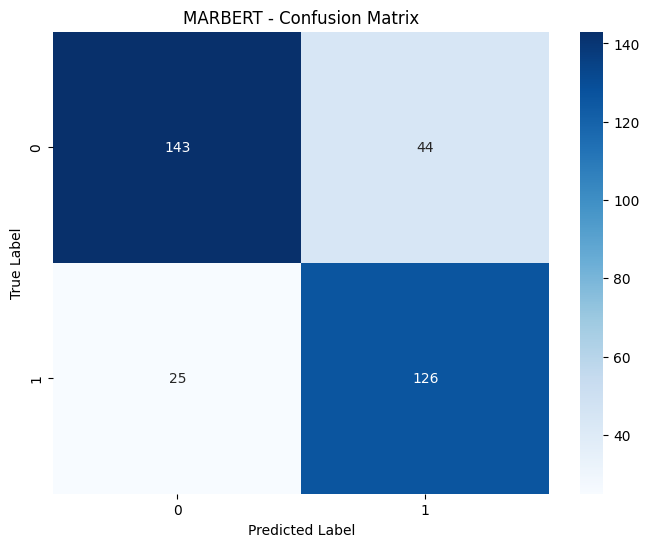


MARBERT Accuracy: 0.7959
MARBERT F1 Score: 0.7964


In [11]:
# Evaluate MARBERT
marbert_results = evaluate_model(marbert_trainer, marbert_test_dataset, "MARBERT")
print(f"\nMARBERT Accuracy: {marbert_results['accuracy']:.4f}")
print(f"MARBERT F1 Score: {marbert_results['f1']:.4f}")

## Train MARBERT v2 Model

In [12]:
# Load MARBERT v2 tokenizer and model
marbertv2_model_name = "UBC-NLP/MARBERTv2"
print(f"Loading {marbertv2_model_name}...")

marbertv2_tokenizer = AutoTokenizer.from_pretrained(marbertv2_model_name)
marbertv2_model = AutoModelForSequenceClassification.from_pretrained(
    marbertv2_model_name,
    num_labels=2
)

# Tokenize datasets
print("Tokenizing datasets...")
marbertv2_train_dataset = train_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)
marbertv2_test_dataset = test_dataset.map(
    lambda x: tokenize_function(x, marbertv2_tokenizer),
    batched=True
)

print(f"Train dataset size: {len(marbertv2_train_dataset)}")
print(f"Test dataset size: {len(marbertv2_test_dataset)}")

Loading UBC-NLP/MARBERTv2...


tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...


Map:   0%|          | 0/3042 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

Train dataset size: 3042
Test dataset size: 338


In [13]:
# Set up training arguments for MARBERT v2
training_args_v2 = TrainingArguments(
    output_dir='./results_marbertv2',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_marbertv2',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=RANDOM_STATE
)

# Create data collator for dynamic padding
data_collator_v2 = DataCollatorWithPadding(tokenizer=marbertv2_tokenizer)

# Create Trainer
marbertv2_trainer = Trainer(
    model=marbertv2_model,
    args=training_args_v2,
    train_dataset=marbertv2_train_dataset,
    eval_dataset=marbertv2_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator_v2
)

# Train the model
print("Training MARBERT v2...")
marbertv2_trainer.train()
print("Training complete!")

Training MARBERT v2...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648700,0.393840,0.813609,0.813270
2,0.337300,0.505711,0.795858,0.793422
3,0.226800,0.703231,0.816568,0.817084


Training complete!


## Evaluate MARBERT v2 Model


Evaluating MARBERT v2



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.79      0.83       187
     Class 1       0.77      0.85      0.81       151

    accuracy                           0.82       338
   macro avg       0.82      0.82      0.82       338
weighted avg       0.82      0.82      0.82       338



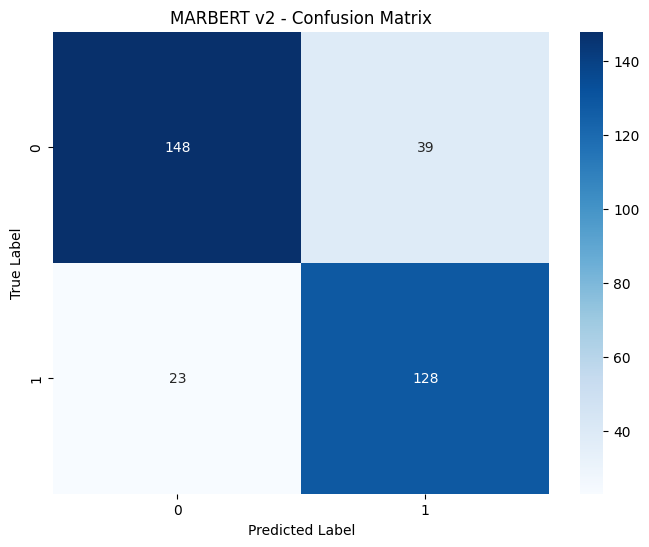


MARBERT v2 Accuracy: 0.8166
MARBERT v2 F1 Score: 0.8171


In [14]:
# Evaluate MARBERT v2
marbertv2_results = evaluate_model(marbertv2_trainer, marbertv2_test_dataset, "MARBERT v2")
print(f"\nMARBERT v2 Accuracy: {marbertv2_results['accuracy']:.4f}")
print(f"MARBERT v2 F1 Score: {marbertv2_results['f1']:.4f}")

## Compare Results: MARBERT vs MARBERT v2


FINAL RESULTS COMPARISON
     Model  Accuracy  F1 Score
   MARBERT  0.795858  0.796437
MARBERT v2  0.816568  0.817084


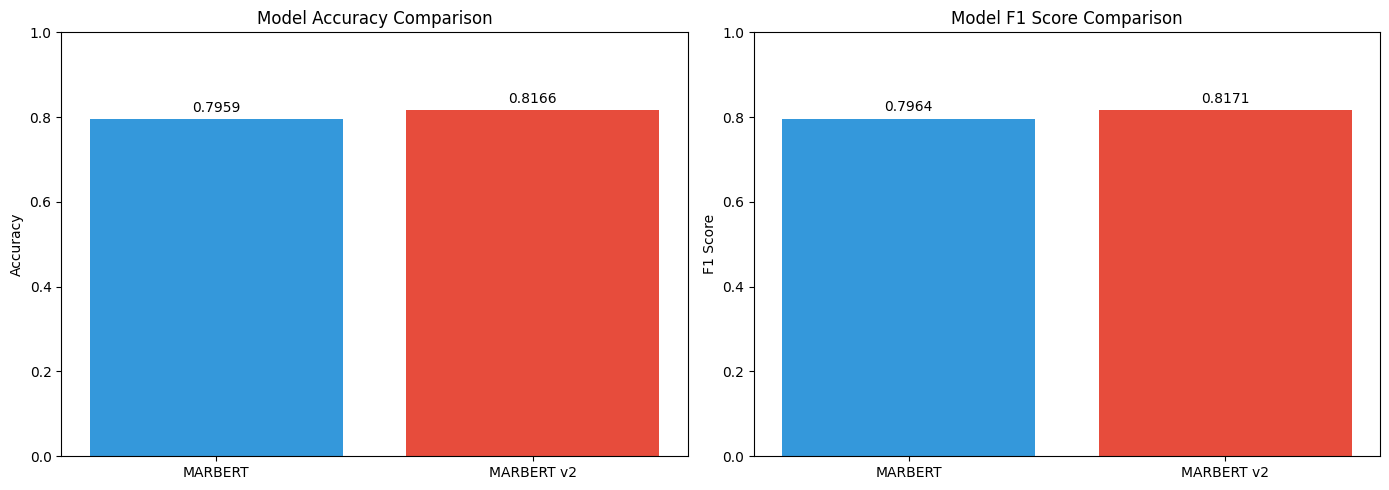


🏆 Winner: MARBERT v2
   Improvement: +0.0206 F1 score


In [15]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['MARBERT', 'MARBERT v2'],
    'Accuracy': [marbert_results['accuracy'], marbertv2_results['accuracy']],
    'F1 Score': [marbert_results['f1'], marbertv2_results['f1']]
})

print("\n" + "="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
models = ['MARBERT', 'MARBERT v2']
accuracy_scores = [marbert_results['accuracy'], marbertv2_results['accuracy']]
ax1.bar(models, accuracy_scores, color=['#3498db', '#e74c3c'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 1])
for i, v in enumerate(accuracy_scores):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# F1 Score comparison
f1_scores = [marbert_results['f1'], marbertv2_results['f1']]
ax2.bar(models, f1_scores, color=['#3498db', '#e74c3c'])
ax2.set_ylabel('F1 Score')
ax2.set_title('Model F1 Score Comparison')
ax2.set_ylim([0, 1])
for i, v in enumerate(f1_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine winner
if marbert_results['f1'] > marbertv2_results['f1']:
    winner = "MARBERT"
    improvement = marbert_results['f1'] - marbertv2_results['f1']
elif marbertv2_results['f1'] > marbert_results['f1']:
    winner = "MARBERT v2"
    improvement = marbertv2_results['f1'] - marbert_results['f1']
else:
    winner = "TIE"
    improvement = 0

print(f"\n🏆 Winner: {winner}")
if winner != "TIE":
    print(f"   Improvement: +{improvement:.4f} F1 score")

In [ ]:
## Analyze Misclassified Examples

# Get misclassifications for MARBERT
marbert_predictions = marbert_trainer.predict(marbert_test_dataset)
marbert_preds = np.argmax(marbert_predictions.predictions, axis=1)
marbert_labels = marbert_predictions.label_ids

# Get misclassifications for MARBERT v2
marbertv2_predictions = marbertv2_trainer.predict(marbertv2_test_dataset)
marbertv2_preds = np.argmax(marbertv2_predictions.predictions, axis=1)
marbertv2_labels = marbertv2_predictions.label_ids

# Find misclassified indices
marbert_misclassified_idx = np.where(marbert_preds != marbert_labels)[0]
marbertv2_misclassified_idx = np.where(marbertv2_preds != marbertv2_labels)[0]

print("="*100)
print("MISCLASSIFIED EXAMPLES ANALYSIS")
print("="*100)

print(f"\nMARBERT Misclassifications: {len(marbert_misclassified_idx)} / {len(marbert_labels)} ({len(marbert_misclassified_idx)/len(marbert_labels)*100:.2f}%)")
print(f"MARBERT v2 Misclassifications: {len(marbertv2_misclassified_idx)} / {len(marbertv2_labels)} ({len(marbertv2_misclassified_idx)/len(marbertv2_labels)*100:.2f}%)")

# Display MARBERT misclassified examples
print("\n" + "="*100)
print("MARBERT MISCLASSIFIED EXAMPLES (First 5)")
print("="*100)

for i, idx in enumerate(marbert_misclassified_idx[:5]):
    text = test_df.iloc[idx]['text']
    true_label = marbert_labels[idx]
    pred_label = marbert_preds[idx]
    
    print(f"\n{'-'*100}")
    print(f"Example {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected Label: {true_label}")
    print(f"  Predicted Label: {pred_label}")
    print(f"  Error Type: {'False Positive' if pred_label == 1 else 'False Negative'}")

# Display MARBERT v2 misclassified examples
print("\n" + "="*100)
print("MARBERT v2 MISCLASSIFIED EXAMPLES (First 5)")
print("="*100)

for i, idx in enumerate(marbertv2_misclassified_idx[:5]):
    text = test_df.iloc[idx]['text']
    true_label = marbertv2_labels[idx]
    pred_label = marbertv2_preds[idx]
    
    print(f"\n{'-'*100}")
    print(f"Example {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected Label: {true_label}")
    print(f"  Predicted Label: {pred_label}")
    print(f"  Error Type: {'False Positive' if pred_label == 1 else 'False Negative'}")

# Error distribution analysis
print("\n" + "="*100)
print("ERROR DISTRIBUTION ANALYSIS")
print("="*100)

# MARBERT error types
marbert_false_positives = np.sum((marbert_preds == 1) & (marbert_labels == 0))
marbert_false_negatives = np.sum((marbert_preds == 0) & (marbert_labels == 1))

print(f"\nMARBERT:")
print(f"  False Positives (Predicted 1, Actually 0): {marbert_false_positives}")
print(f"  False Negatives (Predicted 0, Actually 1): {marbert_false_negatives}")

# MARBERT v2 error types
marbertv2_false_positives = np.sum((marbertv2_preds == 1) & (marbertv2_labels == 0))
marbertv2_false_negatives = np.sum((marbertv2_preds == 0) & (marbertv2_labels == 1))

print(f"\nMARBERT v2:")
print(f"  False Positives (Predicted 1, Actually 0): {marbertv2_false_positives}")
print(f"  False Negatives (Predicted 0, Actually 1): {marbertv2_false_negatives}")

# Visualize error types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MARBERT error types
error_types = ['False Positive', 'False Negative']
marbert_errors = [marbert_false_positives, marbert_false_negatives]
ax1.bar(error_types, marbert_errors, color=['#e74c3c', '#f39c12'])
ax1.set_ylabel('Count')
ax1.set_title('MARBERT Error Types')
for i, v in enumerate(marbert_errors):
    ax1.text(i, v + 1, str(v), ha='center', fontweight='bold')

# MARBERT v2 error types
marbertv2_errors = [marbertv2_false_positives, marbertv2_false_negatives]
ax2.bar(error_types, marbertv2_errors, color=['#e74c3c', '#f39c12'])
ax2.set_ylabel('Count')
ax2.set_title('MARBERT v2 Error Types')
for i, v in enumerate(marbertv2_errors):
    ax2.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
## Detailed Error Type Analysis - Separated Lists

# Get false positives and false negatives separately for MARBERT
marbert_fp_idx = np.where((marbert_preds == 1) & (marbert_labels == 0))[0]
marbert_fn_idx = np.where((marbert_preds == 0) & (marbert_labels == 1))[0]

# Get false positives and false negatives separately for MARBERT v2
marbertv2_fp_idx = np.where((marbertv2_preds == 1) & (marbertv2_labels == 0))[0]
marbertv2_fn_idx = np.where((marbertv2_preds == 0) & (marbertv2_labels == 1))[0]

print("="*100)
print("MARBERT - DETAILED ERROR ANALYSIS")
print("="*100)

print(f"\n🔴 FALSE POSITIVES (Predicted 1, Actually 0) - Total: {len(marbert_fp_idx)}")
print("-"*100)
for i, idx in enumerate(marbert_fp_idx[:3]):
    text = test_df.iloc[idx]['text']
    print(f"\nExample {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected: 0 | Predicted: 1")

print(f"\n\n🔵 FALSE NEGATIVES (Predicted 0, Actually 1) - Total: {len(marbert_fn_idx)}")
print("-"*100)
for i, idx in enumerate(marbert_fn_idx[:3]):
    text = test_df.iloc[idx]['text']
    print(f"\nExample {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected: 1 | Predicted: 0")

print("\n" + "="*100)
print("MARBERT v2 - DETAILED ERROR ANALYSIS")
print("="*100)

print(f"\n🔴 FALSE POSITIVES (Predicted 1, Actually 0) - Total: {len(marbertv2_fp_idx)}")
print("-"*100)
for i, idx in enumerate(marbertv2_fp_idx[:3]):
    text = test_df.iloc[idx]['text']
    print(f"\nExample {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected: 0 | Predicted: 1")

print(f"\n\n🔵 FALSE NEGATIVES (Predicted 0, Actually 1) - Total: {len(marbertv2_fn_idx)}")
print("-"*100)
for i, idx in enumerate(marbertv2_fn_idx[:3]):
    text = test_df.iloc[idx]['text']
    print(f"\nExample {i+1}:")
    print(f"  Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"  Expected: 1 | Predicted: 0")